In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Parameters

In [10]:
params = [0.0027785399344,8.0,0.868,0.108,584.0,1503.0,0.000289,0.000214,0.000128,-8.83e-6,0.88,0.0189,0.012101809339,2.85,0.0006630000000000001,95.0,0.00074619,0.075,0.00033572,5.37,0.0689,127.0,2043.0,0.00395,0.00185,0.00061,-0.000505,0.88,0.184972339613,450.0,219.7085301388,0.0,-3.71,0.53,0.226,23.0,0.058786935033,0.29,0.006,0.037,0.0034,5.0,1.3,0.12,1.78,0.12,3.2,5.2,3.001011022378,3.094711690204,5.674773816316,6.290803221796,8.498343729591,14.36664496926,0.0,0.0,1.0,0.88,1.0,0.88,5.003761571969437,0.11122955089297369,0.4,0.1,21.82854404275587,22.99050845201536,1.0,0.0,1.0,-1.0,1.0,1.0,0.0,1.0,1.0,0.75,0.75,1.7608716659237555,1.6696106891941103,1.0499391485135692,0.0,0.0,0.0003,0.01,0.805,5.184e6,100000.0,200.0,0.5,0.01,0.241,1189.0,0.01,57.4,1.8e6,2.0e6,100000.0,1000.0,0.00091,13.5,1.0,1.0,1.0,1.0,1.0]
ics = [0.322114215761171,0.201296960359917,0.63896741190756,0.00663104034826483,0.0112595761822961,0.0652960640300348,1.7882958476437,7.05727560072869,7.05714474742141,0.0,0.0,0.0,0.0,3.34289716182018,3.69277248068433,3.87942133769244,3.90061903207543,3.77875734283571,3.55364471589659,320.0,80.0,680.0,5.0e9,5.0,240.0]

## System of ODEs

In [30]:
def thyrosimIM(q, t, p):
    kdelay = 5/8

    # scaling the mass/concentration of compartments
    plasma_volume_ratio = p[68]**p[70]
    slow_volume_ratio = p[73]**p[70]
    fast_volume_ratio = p[74]**p[70]

    # scale compartment sizes
    q1 = q[0] * 1 / p[68]
    q2 = q[1] * 1 / p[74]
    q3 = q[2] * 1 / p[73]
    q4 = q[3] * 1 / p[68]
    q5 = q[4] * 1 / p[74]
    q6 = q[5] * 1 / p[73]
    q7 = q[6] * 1 / p[68]

    # Auxillary equations
    q4F = (p[23] + p[24] * q1 + p[25] * q1**2 + p[26] * q1**3) * q4  # FT3p
    q1F = (p[6] + p[7] * q1 + p[8] * q1**2 + p[9] * q1**3) * q1  # FT4p
    SR3 = (q[23]/p[99]) * (p[18] * p[58] * q[18])  # Scaled (q[23]/p[98]) Brain delay (dial 3)
    SR4 = (q[23]/p[99]) * (p[0] * p[56] * q[18])  # Scaled (q[23]/p[98]) Brain delay (dial 1)
    fCIRC = q[8]**p[50] / (q[8]**p[50] + p[48]**p[50])
    SRTSH = (p[29] + p[30] * fCIRC * np.sin(np.pi/12 * t - p[32])) * (p[49]**p[51] / (p[49]**p[51] + q[8]**p[51]))
    fdegTSH = p[33] + p[34] / (p[35] + q7)
    fLAG = p[40] + 2 * q[7]**11 / (p[41]**11 + q[7]**11)
    f4 = p[36] * (1 + 5 * (p[52]**p[53]) / (p[52]**p[53] + q[7]**p[53]))
    NL = p[12] / (p[13] + q2)

    # ODEs
    dq0 = p[80] + (SR4 + p[2] * q2 + p[3] * q3 - (p[4] + p[5]) * q1F) * plasma_volume_ratio + p[10] * q[10]  # T4dot (need to remove u1)
    dq1 = (p[5] * q1F - (p[2] + p[11] + NL) * q2) * fast_volume_ratio  # T4fast
    dq2 = (p[4] * q1F - (p[3] + p[14] / (p[15] + q3) + p[16] / (p[17] + q3)) * q3) * slow_volume_ratio  # T4slow
    dq3 = p[81] + (SR3 + p[19] * q5 + p[20] * q6 - (p[21] + p[22]) * q4F) * plasma_volume_ratio + p[27] * q[12]  # T3pdot
    dq4 = (p[22] * q4F + NL * q2 - (p[19] + p[28]) * q5) * fast_volume_ratio  # T3fast
    dq5 = (p[21] * q4F + p[14] * q3 / (p[15] + q3) + p[16] * q3 / (p[17] + q3) - (p[20]) * q6) * slow_volume_ratio  # T3slow
    dq6 = (SRTSH - fdegTSH * q7) * plasma_volume_ratio  # TSHp
    dq7 = f4 / p[37] * q1 + p[36] / p[38] * q4 - p[39] * q[7]  # T3B
    dq8 = fLAG * (q[7] - q[8])  # T3B LAG
    dq9 = -p[42] * q[9]  # T4PILLdot
    dq10 = p[42] * q[9] - (p[43] * p[57] + p[10]) * q[10]  # T4GUTdot: note p[43] * p[57] = p[43] * dial[1] = k4excrete
    dq11 = -p[44] * q[11]  # T3PILLdot
    dq12 = p[44] * q[11] - (p[45] * p[59] + p[27]) * q[12]  # T3GUTdot: note p[45] * p[59] = p[45] * dial[3] = k3excrete

    # Delay ODEs
    dq13 = kdelay * (q7 - q[13])
    dq14 = kdelay * (q[13] - q[14])  # delay2: TSH delay
    dq15 = kdelay * (q[14] - q[15])  # delay3
    dq16 = kdelay * (q[15] - q[16])  # delay4
    dq17 = kdelay * (q[16] - q[17])  # delay5
    dq18 = kdelay * (q[17] - q[18])  # delay6

    # ---------- IMMUNE ODEs ----------
    dq19 = p[82] * (q[22] / (q[22] + p[94])) * q[21] + (p[96] * q1F) - (p[88] + p[83]) * q[19]  # Bdot 
    dq20 = p[83] * q[19] - p[89] * q[20]  # Pdot
    dq21 = p[84] * q[23] + p[97] * q1F - p[98] * (q[22] / (q[22] + p[95])) * q[21] - p[90] * q[21]  # Tdot
    dq22 = p[85] * q[21] - p[91] * q[22]  # Cdot
    dq23 = p[86]*((q7/q[23])*p[99])-p[92]*(q[23])*q[24] # FTSdot 
    dq24 = p[87]*q[20]-q[24]*(p[93]+p[92]*q[23]) # Ab

    return [dq0, dq1, dq2, dq3, dq4, dq5, dq6, dq7, dq8, dq9, dq10, dq11, dq12, dq13, dq14, dq15, dq16, dq17, dq18, dq19, dq20, dq21, dq22, dq23, dq24]

# Example usage:
# time points
time_points = np.linspace(0, 1000, 1000)  # adjust as needed

# solve ODEs
result = odeint(thyrosimIM, ics, time_points, args=(params,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


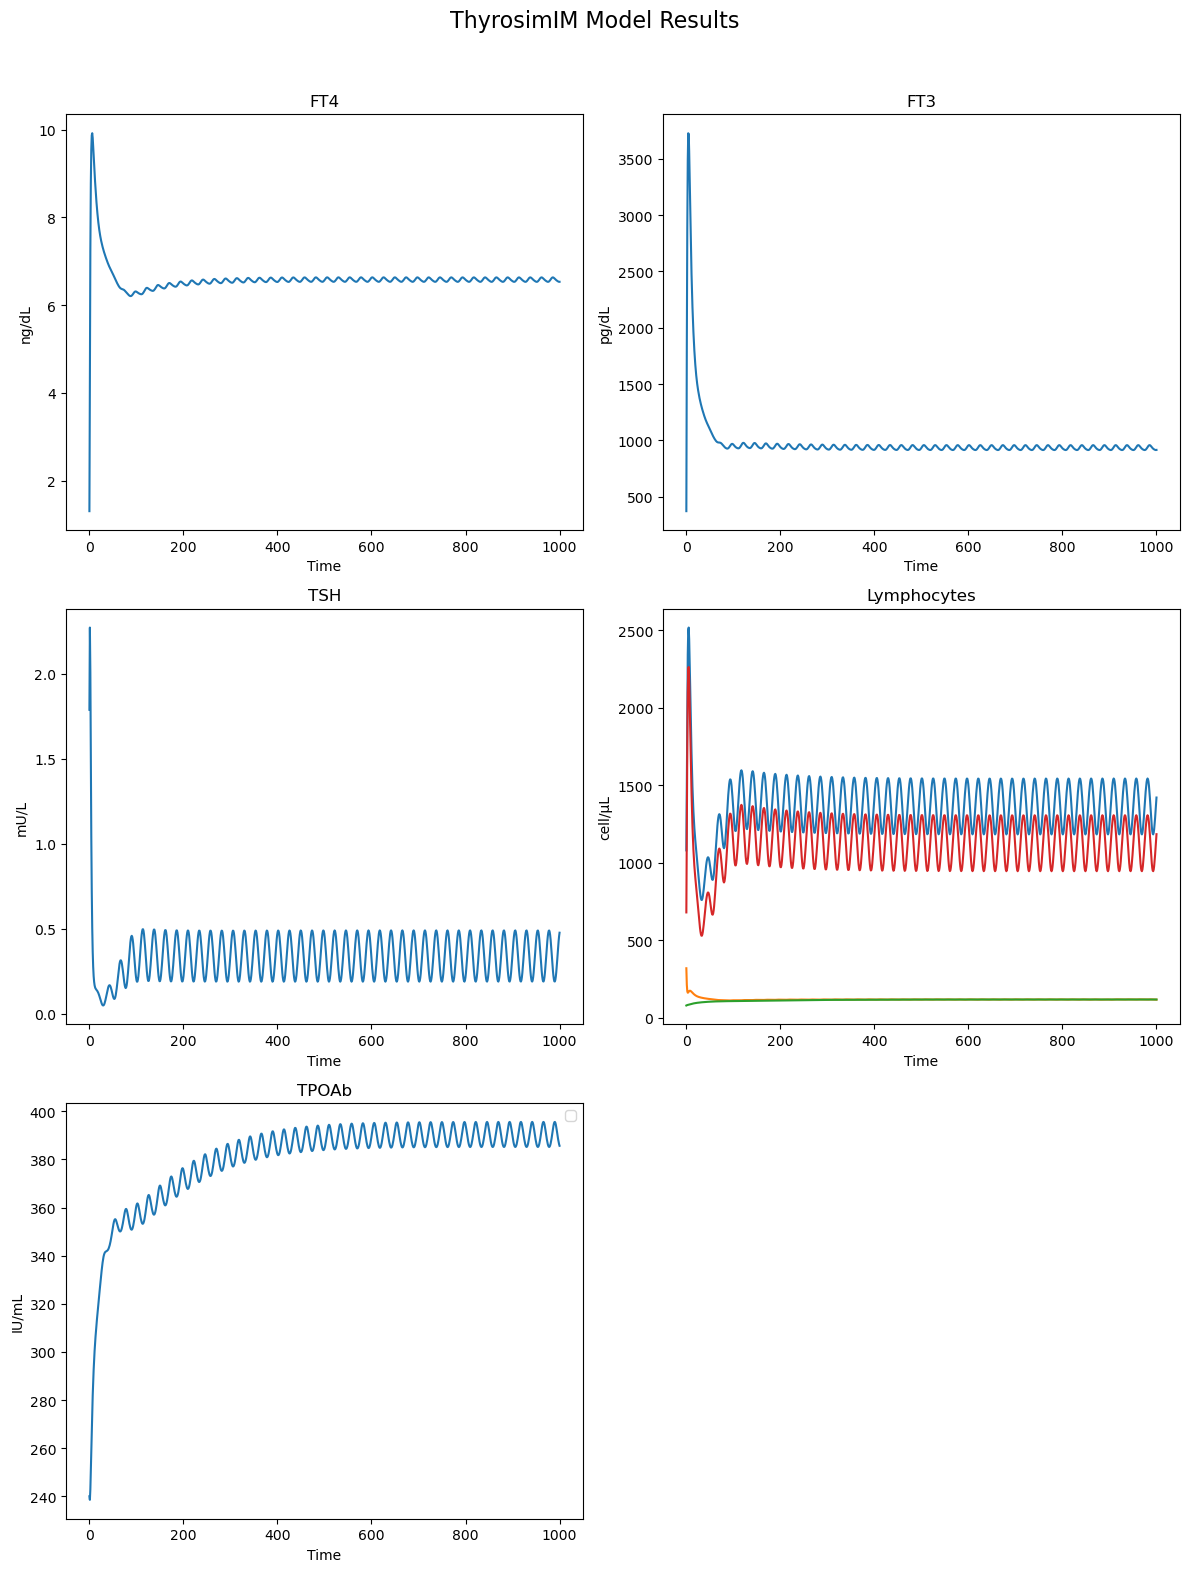

In [37]:
# We run the model using total T4, total T3. These convert to units reported in contemporary labs
def FT4(TT4):
    """
    Converts TT4 (μmol) to FT4 (μg/dL) using Thyrosim's internal 4th order polynomial
    """
    return (0.000289 + (0.000214 * TT4) + (0.000128 * TT4**2) - (8.83e-6 * TT4**3)) * TT4 * 24281.25 * 0.45  # Convert from TT4 to FT4 then from μmol FT4 to μg/dL FT4 via scaling factor

def FT3(TT3):
    """
    Converts TT3 (μmol) to FT3 (μmol) using Thyrosim's internal 4th order polynomial
    """
    return (0.00395 + (0.00185 * TT3) + (0.000610 * TT3**2) - (-0.000505 * TT3**3)) * TT3 * 2830400.35 * 5


def plot_results(solution, time_points):
    # Define subplots
    fig, axs = plt.subplots(3, 2, figsize=(12, 16))
    fig.suptitle('ThyrosimIM Model Results', fontsize=16)

    # Plot FT4
    axs[0, 0].plot(time_points, FT4(solution[:, 0]))
    axs[0, 0].set_ylabel('ng/dL')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_title('FT4')

    # Plot FT3
    axs[0, 1].plot(time_points, FT3(solution[:, 3]))
    axs[0, 1].set_ylabel('pg/dL')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_title('FT3')

    # Plot TSH
    axs[1, 0].plot(time_points, solution[:, 6])
    axs[1, 0].set_ylabel('mU/L')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_title('TSH')

    # Plot Lymphocytes
    axs[1, 1].plot(time_points, (solution[:, 19]+solution[:, 20]+solution[:, 21]), label="Adaptive Lymphocytes")
    axs[1, 1].plot(time_points, solution[:, 19], label="B-Cells")
    axs[1, 1].plot(time_points, solution[:, 20], label="Plasma Cells")
    axs[1, 1].plot(time_points, solution[:, 21], label="T-Cells")
    axs[1, 1].set_ylabel("cell/μL")
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_title('Lymphocytes')

    # Plot TPOAb
    axs[2, 0].plot(time_points, solution[:, 24])
    axs[2, 0].set_ylabel('IU/mL')
    axs[2, 0].set_xlabel('Time')
    axs[2, 0].set_title('TPOAb')

    # Remove empty subplot
    fig.delaxes(axs[2, 1])
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage:
# Assuming 'result' contains the solution and 'time_points' is the corresponding time array
plot_results(result, time_points)

Note that these values are **not** fit to the data. That's what we are working on right now. However, you should still be able to test your parameter sensitivity software by generating some sample data. If you want to try and code something up to fit the model to average values, that would be really cool too. You can also tell the initial values are not great because of the large jumps at the beginning before the variables reach steady state.

If you have any questions or want to meet for a quick call over zoom to talk about the model, send me an email at [aidan.boyne@bcm.edu](mailto:aidan.boyne@bcm.edu)